# Running actual hypothesis test with pre-computed standard errors

In [14]:
import scanpy as sc
import scipy.stats as stats
import scipy.sparse as sparse
import pandas as pd
import numpy as np
import string
import random
# import estimators as memento

import seaborn as sns
import tiledb
import statsmodels.api as sm
from pymare import estimators, core


In [49]:
import tiledb
estimators = tiledb.open('estimators_cube_test').df[:]

In [50]:
np.nansum

<function numpy.nansum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>

In [51]:
estimators

,cell_type,dataset_id,assay,suspension_type,donor_id,disease,sex,feature_id,nnz,n_obs,min,max,sum,mean,sem,var,sev,selv
0,CD14-positive monocyte,86282760-5099-4c71-8cdd-412dcbbbd0b9,10x 5' v1,cell,D1,Down syndrome,male,ENSG00000135636,26.0,320.0,1.0,6.0,60.0,0.190031,0.001609,0.193269,0.057532,0.318559
1,CD14-positive monocyte,86282760-5099-4c71-8cdd-412dcbbbd0b9,10x 5' v1,cell,D2,Down syndrome,female,ENSG00000135636,22.0,320.0,1.0,5.0,42.0,0.133956,0.001020,0.168847,0.067813,0.462170
2,CD14-positive monocyte,86282760-5099-4c71-8cdd-412dcbbbd0b9,10x 5' v1,cell,D3,Down syndrome,male,ENSG00000135636,20.0,320.0,1.0,4.0,40.0,0.127726,0.000967,0.077762,0.024635,0.355276
3,CD14-positive monocyte,86282760-5099-4c71-8cdd-412dcbbbd0b9,10x 5' v1,cell,D4,Down syndrome,male,ENSG00000135636,87.0,320.0,1.0,5.0,155.0,0.485981,0.002714,0.493239,0.109993,0.231134
4,CD14-positive monocyte,86282760-5099-4c71-8cdd-412dcbbbd0b9,10x 5' v1,cell,pooled,Down syndrome,male,ENSG00000135636,1.0,320.0,1.0,1.0,1.0,0.006231,0.000010,0.000000,0.000000,0.000000


In [15]:
cube_path = '~/Github/'

In [16]:
X = np.random.random(size=(10, 5))

In [40]:
samples = stats.norm.rvs(scale=2, size=(1000, 1000))

In [41]:
sums = samples.sum(axis=0)

In [42]:
samples.var(axis=0).mean()*1000

4000.7992246065937

In [43]:
sums.var()

3902.5082905978497

<Axes: ylabel='Density'>

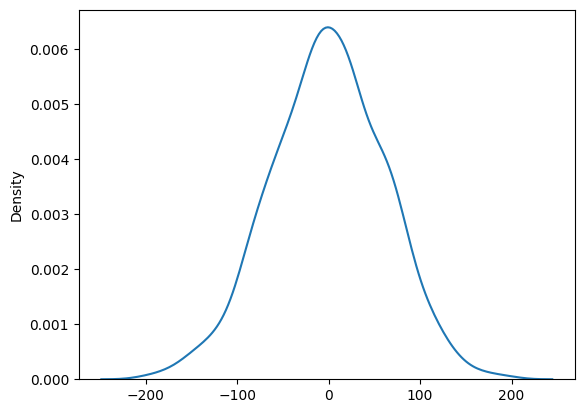

In [44]:
sns.kdeplot(sums)

In [8]:
X.std()

0.2744020412801632

### Read summary cube

In [15]:
estimators = tiledb.open(cube_path +'estimators_cube').df[:]

In [16]:
estimators

,cell_type,dataset_id,feature_id,nnz,n_obs,min,max,sum,mean,sem,var,sev,selv
0,CD14-positive monocyte,343ff97c-85df-494b-8400-beb937618611,ENSG00000000003,3.0,1384.0,1.0,1.0,3.0,2.508446e-07,2.667985e-08,9.851512e-13,NaN,NaN
1,CD14-positive monocyte,343ff97c-85df-494b-8400-beb937618611,ENSG00000000419,258.0,1384.0,1.0,5.0,327.0,2.734206e-05,8.193468e-07,9.291197e-10,2.498065e-10,0.280973
2,CD14-positive monocyte,343ff97c-85df-494b-8400-beb937618611,ENSG00000000457,37.0,1384.0,1.0,2.0,40.0,3.344595e-06,2.744827e-07,1.042716e-10,4.417120e-11,0.444606
3,CD14-positive monocyte,343ff97c-85df-494b-8400-beb937618611,ENSG00000000460,47.0,1384.0,1.0,2.0,51.0,4.264359e-06,3.387977e-07,1.588609e-10,6.063400e-11,0.417331
4,CD14-positive monocyte,343ff97c-85df-494b-8400-beb937618611,ENSG00000000938,1008.0,1384.0,1.0,9.0,2107.0,1.761765e-04,2.813568e-06,1.095597e-08,2.220919e-09,0.207314
...,...,...,...,...,...,...,...,...,...,...,...,...,...
857988,stromal cell,86282760-5099-4c71-8cdd-412dcbbbd0b9,ENSG00000279483,4.0,4.0,5.0,8.0,27.0,7.505858e-04,1.374811e-02,7.560416e-04,NaN,NaN
857989,stromal cell,86282760-5099-4c71-8cdd-412dcbbbd0b9,ENSG00000279873,1.0,4.0,1.0,1.0,1.0,2.779947e-05,2.508911e-03,2.517855e-05,NaN,NaN
857990,stromal cell,86282760-5099-4c71-8cdd-412dcbbbd0b9,ENSG00000280071,1.0,4.0,1.0,1.0,1.0,2.779947e-05,2.508911e-03,2.517855e-05,NaN,NaN
857991,stromal cell,86282760-5099-4c71-8cdd-412dcbbbd0b9,ENSG00000280789,2.0,4.0,1.0,1.0,2.0,5.559895e-05,3.548137e-03,5.035709e-05,NaN,NaN


In [17]:
estimators['id'] = estimators['cell_type'] + '^'+ estimators['dataset_id']

In [18]:
expr = estimators.pivot(index='id', columns='feature_id', values='mean')
sem = estimators.pivot(index='id', columns='feature_id', values='sem')
covariates = pd.DataFrame(
    zip(expr.index.str.split('^').str[0], expr.index.str.split('^').str[1]), 
    columns=['ct', 'dataset'],
    index=expr.index)

In [21]:
design_matrix

,ct_promonocyte,dataset_86282760-5099-4c71-8cdd-412dcbbbd0b9,const
id,,,
CD14-positive monocyte^343ff97c-85df-494b-8400-beb937618611,0.0,0.0,1.0
CD14-positive monocyte^86282760-5099-4c71-8cdd-412dcbbbd0b9,0.0,1.0,1.0
promonocyte^343ff97c-85df-494b-8400-beb937618611,1.0,0.0,1.0
promonocyte^86282760-5099-4c71-8cdd-412dcbbbd0b9,1.0,1.0,1.0


In [20]:
ct1= 'CD14-positive monocyte'
ct2 = 'promonocyte'

groups = [g for g in expr.index if ct1 in g or ct2 in g]
design_matrix = sm.add_constant(pd.get_dummies(covariates.loc[groups], drop_first=True), prepend=False).astype(float)

ct_expr = expr.loc[groups].dropna(axis=1)
ct_sem = sem.loc[groups, ct_expr.columns]
ct_var = ct_sem**2

ct_log_expr = np.log(ct_expr)
l = np.log(ct_expr - ct_sem)
u = np.log(ct_expr + ct_sem)
ct_log_sem = (u-l)/2
ct_log_var = ct_log_sem**2

idx=0
sm.WLS(ct_log_expr.values[:, [idx]], design_matrix.values, weights=ct_log_var.values[:, idx],).fit().summary()

/home/ssm-user/miniconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/ssm-user/miniconda3/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     144.9
Date:                Fri, 30 Jun 2023   Prob (F-statistic):             0.0586
Time:                        10:55:28   Log-Likelihood:                 12.540
No. Observations:                   4   AIC:                            -19.08
Df Residuals:                       1   BIC:                            -20.92
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2137      0.020     10.835      0.059      -0.037       0.464
x2            -0.3188      0.023    -14.146      0.045      -0.605      -0.032
const        -10.5214      0.021   -499.562      0.001     -10.789     -10.254
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.946
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.516
Skew:                          -0.046   Prob(JB):                        0.772
Kurtosis:                       1.242   Cond. No.                         4.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/ssm-user/miniconda3/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     144.9
Date:                Fri, 30 Jun 2023   Prob (F-statistic):             0.0586
Time:                        10:44:51   Log-Likelihood:                 12.540
No. Observations:                   4   AIC:                            -19.08
Df Residuals:                       1   BIC:                            -20.92
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2137      0.020     10.835      0.059      -0.037       0.464
x2            -0.3188      0.023    -14.146      0.045      -0.605      -0.032
const        -10.5214      0.021   -499.562      0.001     -10.789     -10.254
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.946
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.516
Skew:                          -0.046   Prob(JB):                        0.772
Kurtosis:                       1.242   Cond. No.                         4.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
dataset.to_df()

AttributeError: 'Dataset' object has no attribute 'to_df'

In [104]:
dataset

In [39]:
design_matrix

,ct_CD14-positive monocyte,ct_promonocyte,dataset_343ff97c-85df-494b-8400-beb937618611,dataset_86282760-5099-4c71-8cdd-412dcbbbd0b9
id,,,,
CD14-positive monocyte^343ff97c-85df-494b-8400-beb937618611,True,False,True,False
CD14-positive monocyte^86282760-5099-4c71-8cdd-412dcbbbd0b9,True,False,False,True
promonocyte^343ff97c-85df-494b-8400-beb937618611,False,True,True,False
promonocyte^86282760-5099-4c71-8cdd-412dcbbbd0b9,False,True,False,True


In [37]:
groups

['CD14-positive monocyte^343ff97c-85df-494b-8400-beb937618611',
 'CD14-positive monocyte^86282760-5099-4c71-8cdd-412dcbbbd0b9',
 'promonocyte^343ff97c-85df-494b-8400-beb937618611',
 'promonocyte^86282760-5099-4c71-8cdd-412dcbbbd0b9']

In [ ]:
mean

In [22]:
estimators.query('cell_type == "CD14-positive monocyte" & feature_id == "ENSG00000000419"')

,cell_type,dataset_id,feature_id,nnz,n_obs,min,max,sum,mean,sem,var,sev,selv
1,CD14-positive monocyte,343ff97c-85df-494b-8400-beb937618611,ENSG00000000419,258.0,1384.0,1.0,5.0,327.0,0.000027,8.193468e-07,9.291197e-10,2.498065e-10,0.280973
19747,CD14-positive monocyte,86282760-5099-4c71-8cdd-412dcbbbd0b9,ENSG00000000419,46.0,320.0,1.0,2.0,51.0,0.000019,8.858430e-07,2.511097e-10,1.609582e-10,0.892933


In [21]:
estimators.groupby(['cell_type', 'feature_id']).size()

cell_type               feature_id     
CD14-positive monocyte  ENSG00000000003    1
                        ENSG00000000419    2
                        ENSG00000000457    2
                        ENSG00000000460    2
                        ENSG00000000938    2
                                          ..
stromal cell            ENSG00000279483    1
                        ENSG00000279873    1
                        ENSG00000280071    1
                        ENSG00000280789    1
                        ENSG00000281649    1
Length: 612850, dtype: int64

In [12]:
estimators['mean']

0         2.508446e-07
1         2.734206e-05
2         3.344595e-06
3         4.264359e-06
4         1.761765e-04
              ...     
857988    7.505858e-04
857989    2.779947e-05
857990    2.779947e-05
857991    5.559895e-05
857992    2.779947e-05
Name: mean, Length: 857993, dtype: float64